<a href="https://colab.research.google.com/github/kurtsenol/machine-learning/blob/master/TopicModeling/LDA_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import pickle

In [ ]:
df = pd.read_pickle("drive/My Drive/Topic_Modeling/topic_df.pkl")

In [ ]:
df

,Title,Journal,Year,Abstract
0,TWO-DIRECTIONAL CONVERGENCE OF PLATFORM AND PI...,JOURNAL OF SERVICE MANAGEMENT,2020,PURPOSE THIS ARTICLE EXAMINES THE NEW PHENOMEN...
1,EMPLOYEE WELLNESS ON THE FRONTLINE: AN INTERAC...,JOURNAL OF SERVICE MANAGEMENT,2020,PURPOSE EMPLOYEE WELLNESS IS VITAL TO CREATING...
2,DEMOGRAPHIC AND ATTITUDINAL ANTECEDENTS OF CON...,JOURNAL OF SERVICE MANAGEMENT,2020,PURPOSE TO INVESTIGATE IF ONLINE TV CONTENT PL...
3,MORE THAN A FEELING? TOWARD A THEORY OF CUSTOM...,JOURNAL OF SERVICE MANAGEMENT,2020,PURPOSE RESPONDING TO AN INCREASING CALL FOR A...
4,ACCOUNTABLE ALGORITHMS? THE ETHICAL IMPLICATIO...,JOURNAL OF SERVICE MANAGEMENT,2020,PURPOSE THE PURPOSE OF THIS STUDY IS TO IDENTI...
...,...,...,...,...
11380,TOURIST INFORMATION SEARCH AND DESTINATION CHO...,TOURISM MANAGEMENT PERSPECTIVES,2012,THIS STUDY PROVIDES EMPIRICAL EVIDENCE OF SELF...
11381,TOURISTS' OPINIONS AND THEIR SELECTION OF TOUR...,TOURISM MANAGEMENT PERSPECTIVES,2012,IMAGE IS AN IMPORTANT COMPONENT OF TOURISM DES...
11382,TOWARDS A COMMON AGENDA FOR THE DEVELOPMENT OF...,TOURISM MANAGEMENT PERSPECTIVES,2012,BUILDING ON CASE STUDIES OF FOUR EUROPEAN REGI...
11383,TOWARDS TOURISM INNOVATION: A CRITICAL REVIEW ...,TOURISM MANAGEMENT PERSPECTIVES,2012,UNDERSTANDING AND MANAGING THE RURAL TOURISM E...


In [ ]:
papers = list(df.Abstract.values)

In [ ]:
len(papers)

11385

In [ ]:
print(papers[0][:1000])

PURPOSE THIS ARTICLE EXAMINES THE NEW PHENOMENON OF THE CONVERGENCE OF PLATFORM AND PIPELINE BUSINESS MODELS. IT EXAMINES THE POTENTIAL SYNERGIES AND CHALLENGES FOR PLATFORMS TO ADD PIPELINE COMPONENTS AND VICE VERSA FOR PIPELINE BUSINESSES. DESIGN/METHODOLOGY/APPROACH THIS PAPER USES A CONCEPTUAL APPROACH THAT SYNTHESIZES AND INTEGRATES THE LITERATURE FROM SERVICE, HOSPITALITY, AND STRATEGY, AND SUPPLEMENTS THEM WITH TWO ILLUSTRATIVE MINI-CASE STUDIES. FINDINGS WHILE THE EXTANT LITERATURE TYPICALLY FOCUSES ON THE DICHOTOMY BETWEEN INCUMBENT PIPELINE BUSINESSES THAT CREATE VALUE BY CONTROLLING A LINEAR SERIES OF ACTIVITIES AND NETWORK EFFECTS-DRIVEN PLATFORMS, WE DIFFERENTIATE BETWEEN TWO TYPES OF PLATFORM BUSINESS MODELS (I.E. PLATFORMS WITH ASSET CONTROL AND PLATFORMS WITH PEER-PROVIDED ASSETS). FURTHER, WE IDENTIFY THREE COMMON PATHWAYS OF CONVERGENCE; THAT IS, PIPELINES MOVING TOWARDS (1) PLATFORMS WITH ASSET CONTROL AND (2) THOSE WITH PEER-PROVIDED ASSETS, AND (3) PLATFORMS WITH P

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 2.8MB/s 
     |████████████████████████████████| 552kB 17.2MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=ce55d8ddda1ba8a1e402dd7f95288e95a7df2c954029500dd69d6dc858e7cae7
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=6bc8a77151cbf5286713fbab02c3abf8942d9d31714506d4b9edd85b83554532
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


In [ ]:
!python -m spacy download en_core_web_md

     |████████████████████████████████| 96.4MB 1.2MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-cp36-none-any.whl size=98051305 sha256=d3ecafd027c346d478540780b97661b3487e28d247bb0577916dfb90e1fb855f
  Stored in directory: /tmp/pip-ephem-wheel-cache-0m80j4g0/wheels/df/94/ad/f5cf59224cea6b5686ac4fd1ad19c8a07bc026e13c36502d81
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [ ]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [ ]:
# Convert to list
data = df.Abstract.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['PURPOSE THIS ARTICLE EXAMINES THE NEW PHENOMENON OF THE CONVERGENCE OF '
 'PLATFORM AND PIPELINE BUSINESS MODELS. IT EXAMINES THE POTENTIAL SYNERGIES '
 'AND CHALLENGES FOR PLATFORMS TO ADD PIPELINE COMPONENTS AND VICE VERSA FOR '
 'PIPELINE BUSINESSES. DESIGN/METHODOLOGY/APPROACH THIS PAPER USES A '
 'CONCEPTUAL APPROACH THAT SYNTHESIZES AND INTEGRATES THE LITERATURE FROM '
 'SERVICE, HOSPITALITY, AND STRATEGY, AND SUPPLEMENTS THEM WITH TWO '
 'ILLUSTRATIVE MINI-CASE STUDIES. FINDINGS WHILE THE EXTANT LITERATURE '
 'TYPICALLY FOCUSES ON THE DICHOTOMY BETWEEN INCUMBENT PIPELINE BUSINESSES '
 'THAT CREATE VALUE BY CONTROLLING A LINEAR SERIES OF ACTIVITIES AND NETWORK '
 'EFFECTS-DRIVEN PLATFORMS, WE DIFFERENTIATE BETWEEN TWO TYPES OF PLATFORM '
 'BUSINESS MODELS (I.E. PLATFORMS WITH ASSET CONTROL AND PLATFORMS WITH '
 'PEER-PROVIDED ASSETS). FURTHER, WE IDENTIFY THREE COMMON PATHWAYS OF '
 'CONVERGENCE; THAT IS, PIPELINES MOVING TOWARDS (1) PLATFORMS WITH ASSET '
 'CONTROL AND (2) THO

### Tokenize words and Clean-up text

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['purpose', 'this', 'article', 'examines', 'the', 'new', 'phenomenon', 'of', 'the', 'convergence', 'of', 'platform', 'and', 'pipeline', 'business', 'models', 'it', 'examines', 'the', 'potential', 'synergies', 'and', 'challenges', 'for', 'platforms', 'to', 'add', 'pipeline', 'components', 'and', 'vice', 'versa', 'for', 'pipeline', 'businesses', 'design', 'methodology', 'approach', 'this', 'paper', 'uses', 'conceptual', 'approach', 'that', 'synthesizes', 'and', 'integrates', 'the', 'literature', 'from', 'service', 'hospitality', 'and', 'strategy', 'and', 'supplements', 'them', 'with', 'two', 'illustrative', 'mini', 'case', 'studies', 'findings', 'while', 'the', 'extant', 'literature', 'typically', 'focuses', 'on', 'the', 'dichotomy', 'between', 'incumbent', 'pipeline', 'businesses', 'that', 'create', 'value', 'by', 'controlling', 'linear', 'series', 'of', 'activities', 'and', 'network', 'effects', 'driven', 'platforms', 'we', 'differentiate', 'between', 'two', 'types', 'of', 'platform',

### Creating Bigram and Trigram Models

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['purpose', 'this', 'article', 'examines', 'the', 'new', 'phenomenon', 'of', 'the', 'convergence', 'of', 'platform', 'and', 'pipeline', 'business', 'models', 'it', 'examines', 'the', 'potential', 'synergies', 'and', 'challenges', 'for', 'platforms', 'to', 'add', 'pipeline', 'components', 'and', 'vice_versa', 'for', 'pipeline', 'businesses', 'design_methodology_approach', 'this', 'paper', 'uses', 'conceptual', 'approach', 'that', 'synthesizes', 'and', 'integrates', 'the', 'literature', 'from', 'service', 'hospitality', 'and', 'strategy', 'and', 'supplements', 'them', 'with', 'two', 'illustrative', 'mini', 'case', 'studies', 'findings', 'while', 'the', 'extant', 'literature', 'typically', 'focuses', 'on', 'the', 'dichotomy', 'between', 'incumbent', 'pipeline', 'businesses', 'that', 'create', 'value', 'by', 'controlling', 'linear', 'series', 'of', 'activities', 'and', 'network', 'effects', 'driven', 'platforms', 'we', 'differentiate', 'between', 'two', 'types', 'of', 'platform', 'business

### Remove Stopwords, Make Bigrams and Lemmatize

In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

Let’s call the functions in order.

In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['purpose', 'article', 'examine', 'new', 'convergence', 'platform', 'pipeline', 'business', 'model', 'examine', 'potential', 'synergy', 'challenge', 'platform', 'add', 'pipeline', 'component', 'vice_versa', 'pipeline', 'business', 'approach', 'paper', 'use', 'conceptual', 'approach', 'synthesize', 'literature', 'service', 'hospitality', 'strategy', 'supplement', 'illustrative', 'mini', 'case', 'study', 'finding', 'extant', 'literature', 'typically', 'focus', 'dichotomy', 'incumbent', 'pipeline', 'business', 'create', 'value', 'control', 'activity', 'network', 'effect', 'drive', 'platform', 'differentiate', 'type', 'platform', 'business', 'model', 'asset', 'peer', 'provide', 'asset', 'identify', 'common', 'pathway', 'convergence', 'pipeline', 'move', 'asset', 'control', 'peer', 'provide', 'asset', 'platform', 'peer', 'provide', 'asset', 'adopt', 'define', 'business', 'characteristic', 'pipeline', 'furthermore', 'contrast', 'key', 'characteristic', 'business', 'model', 'examine', 'poten

### Create the Dictionary and Corpus needed for Topic Modeling

The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Let’s create them.

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 3), (6, 10), (7, 12), (8, 1), (9, 8), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 2), (17, 3), (18, 6), (19, 1), (20, 2), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 4), (31, 1), (32, 1), (33, 1), (34, 2), (35, 2), (36, 1), (37, 1), (38, 1), (39, 1), (40, 2), (41, 1), (42, 1), (43, 1), (44, 2), (45, 1), (46, 3), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 8), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 6), (63, 11), (64, 8), (65, 5), (66, 1), (67, 6), (68, 1), (69, 1), (70, 1), (71, 2), (72, 1), (73, 2), (74, 3), (75, 1), (76, 1), (77, 1), (78, 1), (79, 7), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1)]]


Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).

For example, (0, 1) above implies, word id 0 occurs once in the first document. Likewise, word id 1 occurs twice and so on.

This is used as the input by the LDA model.

If you want to see what word a given id corresponds to, pass the id as a key to the dictionary.

In [ ]:
id2word[0]

'activity'

Or, you can see a human-readable form of the corpus itself.

In [ ]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('activity', 1),
  ('add', 1),
  ('adopt', 1),
  ('also', 1),
  ('approach', 2),
  ('article', 3),
  ('asset', 10),
  ('business', 12),
  ('case', 1),
  ('challenge', 8),
  ('characteristic', 2),
  ('common', 1),
  ('component', 1),
  ('conceptual', 1),
  ('conceptualize', 1),
  ('consideration', 1),
  ('contrast', 2),
  ('control', 3),
  ('convergence', 6),
  ('create', 1),
  ('define', 2),
  ('develop', 1),
  ('dichotomy', 1),
  ('different', 1),
  ('differentiate', 1),
  ('drive', 1),
  ('effect', 1),
  ('embark', 1),
  ('encounter', 1),
  ('entail', 1),
  ('examine', 4),
  ('extant', 1),
  ('extension', 1),
  ('finally', 1),
  ('finding', 2),
  ('first', 2),
  ('focus', 1),
  ('furthermore', 1),
  ('help', 1),
  ('hospitality', 1),
  ('identify', 2),
  ('illustrative', 1),
  ('implication', 1),
  ('incumbent', 1),
  ('key', 2),
  ('likely', 1),
  ('literature', 3),
  ('manager', 1),
  ('many', 1),
  ('may', 1),
  ('mini', 1),
  ('minor', 1),
  ('mitigate', 1),
  ('model', 8),
  (

### Building the Topic Model

We have everything required to train the LDA model. In addition to the corpus and dictionary, you need to provide the number of topics as well.

Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior.

chunksize is the number of documents to be used in each training chunk. update_every determines how often the model parameters should be updated and passes is the total number of training passes.

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

###  View the topics in LDA model

The above LDA model is built with 20 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.

You can see the keywords for each topic and the weightage(importance) of each keyword using lda_model.print_topics() as shown next.

In [ ]:
# Print the 10 Keywords in 20 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.063*"study" + 0.043*"destination" + 0.033*"relationship" + 0.033*"result" '
  '+ 0.030*"influence" + 0.029*"effect" + 0.023*"model" + 0.022*"examine" + '
  '0.022*"perceive" + 0.020*"finding"'),
 (1,
  '0.083*"port" + 0.079*"attribute" + 0.065*"event" + 0.043*"purchase" + '
  '0.032*"failure" + 0.028*"training" + 0.027*"post" + 0.021*"holiday" + '
  '0.021*"message" + 0.020*"generation"'),
 (2,
  '0.145*"employee" + 0.131*"hospitality" + 0.110*"restaurant" + 0.080*"work" '
  '+ 0.029*"green" + 0.023*"emotion" + 0.018*"engagement" + 0.017*"manager" + '
  '0.015*"stress" + 0.013*"organization"'),
 (3,
  '0.062*"chinese" + 0.045*"target" + 0.043*"cluster" + 0.038*"host" + '
  '0.035*"transportation" + 0.034*"csr" + 0.025*"selection" + '
  '0.022*"diversity" + 0.019*"opinion" + 0.014*"widely"'),
 (4,
  '0.154*"customer" + 0.070*"value" + 0.068*"consumer" + 0.065*"brand" + '
  '0.048*"online" + 0.047*"loyalty" + 0.025*"website" + 0.023*"program" + '
  '0.017*"user" + 0.016*"trust"

### Compute Model Perplexity and Coherence Score
Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is. In my experience, topic coherence score, in particular, has been more helpful.

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.5447116487310035

Coherence Score:  0.33495699810279544


### isualize the topics-keywords
Now that the LDA model is built, the next step is to examine the produced topics and the associated keywords. There is no better tool than pyLDAvis package’s interactive chart and is designed to work well with jupyter notebooks.

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10    -0.335344 -0.004276       1        1  38.762924
0     -0.336888  0.068126       2        1  13.474448
6     -0.316066  0.090971       3        1  10.212879
4     -0.038183 -0.355785       4        1   4.117706
16     0.037095 -0.034954       5        1   3.204194
8      0.055593  0.010923       6        1   3.025516
9      0.009561 -0.122711       7        1   2.809515
2      0.017635 -0.087120       8        1   2.616151
17     0.080738  0.033267       9        1   2.319722
7      0.042505  0.040519      10        1   2.303775
15     0.051738 -0.173961      11        1   2.251080
12     0.034924  0.068188      12        1   2.104497
11     0.085533  0.081944      13        1   1.805795
1      0.076615  0.015986      14        1   1.750045
14     0.072447  0.021731      15        1   1.728195
5      0.060112  0.056560      16        1   1.702115
13     0.106580  0.064264      17        1   1.487179
18     0.093587  0.078486      18        1   1.475706
3      0.101427  0.048498      19        1   1.428073
19     0.100392  0.099344      20        1   1.420484, topic_info=             Term         Freq        Total Category  logprob  loglift
73        service  6525.000000  6525.000000  Default  30.0000  30.0000
380         hotel  9293.000000  9293.000000  Default  29.0000  29.0000
100      customer  6297.000000  6297.000000  Default  28.0000  28.0000
252    experience  5364.000000  5364.000000  Default  27.0000  27.0000
3724      tourist  6043.000000  6043.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
3313     proposal    73.318878    74.232979  Topic20  -5.2383   4.2418
1769        moral    67.790619    68.704720  Topic20  -5.3167   4.2408
1206         lose    66.908775    67.822876  Topic20  -5.3298   4.2406
16809     freight    85.604195   118.766327  Topic20  -5.0834   3.9267
943      economic   179.263077  1711.636108  Topic20  -4.3442   1.9978

[775 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
3291     12  0.997450  accessibility
1776      3  0.997803  accommodation
1184      6  0.992600       accurate
0         1  0.698506       activity
0        12  0.300677       activity
...     ...       ...            ...
536       1  0.773694          would
536       9  0.225563          would
2527     15  0.990825          write
2634      5  0.520498          young
2634     15  0.477717          young

[928 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 1, 7, 5, 17, 9, 10, 3, 18, 8, 16, 13, 12, 2, 15, 6, 14, 19, 4, 20])

### Building LDA Mallet Model
So far you have seen Gensim’s inbuilt version of the LDA algorithm. Mallet’s version, however, often gives a better quality of topics.

Gensim provides a wrapper to implement Mallet’s LDA from within Gensim itself. You only need to download the zipfile, unzip it and provide the path to mallet in the unzipped directory to gensim.models.wrappers.LdaMallet. See how I have done this below.

In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

--2020-06-15 15:49:32--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  17.6MB/s    in 0.9s    

2020-06-15 15:49:33 (17.6 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]



In [ ]:
!unzip mallet-2.0.8.zip

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classify  
  inflating: mallet-2.0.8/bin/text2vectors  
  inflating: mallet-2.0.8/bin/vectors2classify  
  inflating: mallet-2.0.8/bin/vectors2info  
  inflating: mallet-2.0.8/bin/vectors2topics  
  inflating: mallet-2.0.8/bin/vectors2vectors  
  inflating: mallet-2.0.8/build.xml  
   creating: mallet-2.0.8/class/
   creating: mallet-2.0.8/class/cc/
   creating: mallet-2.0.8/class/cc/mallet/
   creating: mallet-2.0.8/class/cc/mallet/classify/
  inflating: mallet-2.0.8/class/cc/mallet/classify/AdaBoost.class  
  in

In [ ]:
mallet_path = '/content/mallet-2.0.8/bin/mallet'

In [ ]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(18,
  [('hotel', 0.16744892324682495),
   ('online', 0.03803147432357813),
   ('price', 0.029748757592490335),
   ('guest', 0.02673476900423339),
   ('review', 0.02282348610344193),
   ('high', 0.01808393152954169),
   ('accommodation', 0.016979569298729985),
   ('study', 0.016680471194551814),
   ('website', 0.01571415424259157),
   ('result', 0.014563776918829376)]),
 (19,
  [('study', 0.06662846852746174),
   ('model', 0.05529180649914054),
   ('implication', 0.0444462634034542),
   ('approach', 0.04123352705246787),
   ('finding', 0.0399238765654416),
   ('develop', 0.0358107555046247),
   ('purpose', 0.03364164688548744),
   ('research', 0.029794548579847754),
   ('propose', 0.025517721208152575),
   ('hospitality', 0.025374478186134076)]),
 (16,
  [('management', 0.056349520900846294),
   ('practice', 0.04592824003916723),
   ('environmental', 0.03436458163336675),
   ('industry', 0.031030704310726694),
   ('strategy', 0.02496910917865386),
   ('sustainability', 0.0240132422539

### How to find the optimal number of topics for LDA?
My approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.

If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

The compute_coherence_values() (see below) trains multiple LDA models and provides the models and their corresponding coherence scores.

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=4)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
import seaborn as sns
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


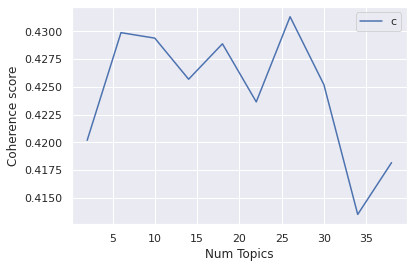

In [ ]:
# Show graph
limit=40; start=2; step=4;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4202
Num Topics = 6  has Coherence Value of 0.4299
Num Topics = 10  has Coherence Value of 0.4294
Num Topics = 14  has Coherence Value of 0.4257
Num Topics = 18  has Coherence Value of 0.4289
Num Topics = 22  has Coherence Value of 0.4236
Num Topics = 26  has Coherence Value of 0.4313
Num Topics = 30  has Coherence Value of 0.4252
Num Topics = 34  has Coherence Value of 0.4135
Num Topics = 38  has Coherence Value of 0.4182


If the coherence score seems to keep increasing, it may make better sense to pick the model that gave the highest CV before flattening out. This is exactly the case here.

So for further steps I will choose the model with 10 topics itself.

In [ ]:
# Select the model and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.070*"research" + 0.030*"approach" + 0.025*"paper" + 0.025*"brand" + '
  '0.024*"hospitality" + 0.023*"literature" + 0.022*"implication" + '
  '0.020*"study" + 0.020*"provide" + 0.015*"finding"'),
 (1,
  '0.030*"consumer" + 0.027*"study" + 0.027*"influence" + 0.025*"intention" + '
  '0.023*"perceive" + 0.021*"information" + 0.020*"image" + 0.020*"perception" '
  '+ 0.020*"online" + 0.019*"restaurant"'),
 (2,
  '0.024*"tourism" + 0.023*"impact" + 0.019*"economic" + 0.019*"country" + '
  '0.016*"time" + 0.014*"result" + 0.014*"price" + 0.014*"demand" + '
  '0.014*"growth" + 0.014*"increase"'),
 (3,
  '0.079*"service" + 0.068*"customer" + 0.038*"study" + 0.027*"quality" + '
  '0.027*"experience" + 0.024*"satisfaction" + 0.019*"finding" + '
  '0.018*"loyalty" + 0.015*"implication" + 0.014*"purpose"'),
 (4,
  '0.049*"relationship" + 0.040*"effect" + 0.036*"employee" + 0.026*"study" + '
  '0.022*"work" + 0.021*"behavior" + 0.020*"role" + 0.018*"result" + '
  '0.016*"positive" + 0.01

### Finding the dominant topic in each sentence
One of the practical application of topic modeling is to determine what topic a given document is about.

To find that, we find the topic number that has the highest percentage contribution in that document.

The format_topics_sentences() function below nicely aggregates this information in a presentable table.

In [ ]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)



In [ ]:

df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,7.0,0.3338,"industry, performance, management, strategy, b...",PURPOSE THIS ARTICLE EXAMINES THE NEW PHENOMEN...
1,1,4.0,0.1959,"relationship, effect, employee, study, work, b...",PURPOSE EMPLOYEE WELLNESS IS VITAL TO CREATING...
2,2,1.0,0.1923,"consumer, study, influence, intention, perceiv...",PURPOSE TO INVESTIGATE IF ONLINE TV CONTENT PL...
3,3,3.0,0.3467,"service, customer, study, quality, experience,...",PURPOSE RESPONDING TO AN INCREASING CALL FOR A...
4,4,0.0,0.2852,"research, approach, paper, brand, hospitality,...",PURPOSE THE PURPOSE OF THIS STUDY IS TO IDENTI...
5,5,0.0,0.1755,"research, approach, paper, brand, hospitality,...",PURPOSE ALTHOUGH SOCIAL MEDIA USE HAS BECOME A...
6,6,7.0,0.2109,"industry, performance, management, strategy, b...",PURPOSE THE PURPOSE OF THIS PAPER IS TO CONSID...
7,7,1.0,0.2791,"consumer, study, influence, intention, perceiv...",PURPOSE THIS STUDY AIMS TO INVESTIGATE BYSTAND...
8,8,0.0,0.3053,"research, approach, paper, brand, hospitality,...",PURPOSE THIS PAPER CONSIDERS THE QUESTION: WHA...
9,9,3.0,0.4219,"service, customer, study, quality, experience,...",PURPOSE BRANDS ARE INCREASINGLY CONSIDERING TH...


In [ ]:
a = df_dominant_topic.Keywords[2]

In [ ]:
a

'consumer, study, influence, intention, perceive, information, image, perception, online, restaurant'

In [ ]:
df_dominant_topic.Text[2]

'PURPOSE TO INVESTIGATE IF ONLINE TV CONTENT PLATFORMS CREATE VALUE FOR CONSUMERS (AND INCREASE USE) BY OFFERING ITS USERS THE POSSIBILITY TO SELF-INVEST IN THE SERVICE (BY GIVING PERSONAL CONTENT PREFERENCES). WE LINK DEMOGRAPHIC AND ATTITUDINAL ANTECEDENTS TO THE RELATION BETWEEN SELF-INVESTMENT AND USE. DESIGN/METHODOLOGY/APPROACH DATA WERE COLLECTED TOGETHER WITH A BELGIAN MEDIA COMPANY (N = 4,136). TO TEST THE EFFECTS A LATENT GROWTH MODEL WAS COMPOSED IN A MULTIGROUP SETTING WITH GENDER AS THE GROUPING VARIABLE. THE MODEL IS ANALYZED THROUGH STRUCTURAL EQUATION MODELING IN MPLUS 8.0. FINDINGS IN GENERAL, STRONG RELATIONS BETWEEN SELF-INVESTMENT AND INCREASED USE WERE FOUND, ALTHOUGH THE EFFECT OF SELF-INVESTMENT ON USE WAS STRONGER FOR FEMALE CONSUMERS. FURTHERMORE, WE ESTABLISHED STRONG HEDONIC EFFECTS ON USING AND INVESTING IN THE SERVICE. FOR MEN, EASY TO USE PLATFORMS LEAD TO LESS SELF-INVESTMENT. RESEARCH LIMITATIONS/IMPLICATIONS OUR FINDINGS ARE RESTRICTED TO FREE SERVICES.

### Find the most representative document for each topic
Sometimes just the topic keywords may not be enough to make sense of what a topic is about. So, to help with understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document. 

In [ ]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.5229,"research, approach, paper, brand, hospitality,...",PURPOSE - THE PURPOSE OF THIS STUDY IS TO PROV...
1,1.0,0.5331,"consumer, study, influence, intention, perceiv...",CONSIDERING THE STRONG INFLUENCE OF SOCIAL MED...
2,2.0,0.5563,"tourism, impact, economic, country, time, resu...",TOURISM TRANSPORT PROFOUNDLY AFFECTS ECONOMIC ...
3,3.0,0.5491,"service, customer, study, quality, experience,...",PURPOSE - THIS STUDY AIMS TO FILL A CONCEPTUAL...
4,4.0,0.6136,"relationship, effect, employee, study, work, b...","BASED ON SELF-DETERMINATION THEORY, WE EXAMINE..."


The tabular output above actually has 20 rows, one each for a topic. It has the topic number, the keywords, and the most representative document. The Perc_Contribution column is nothing but the percentage contribution of the topic in the given document.

### Topic distribution across documents
Finally, we want to understand the volume and distribution of topics in order to judge how widely it was discussed. The below table exposes that information.

In [ ]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,7.0,"industry, performance, management, strategy, b...",858.0,0.0754
1.0,4.0,"relationship, effect, employee, study, work, b...",1276.0,0.1121
2.0,1.0,"consumer, study, influence, intention, perceiv...",1443.0,0.1267
3.0,3.0,"service, customer, study, quality, experience,...",862.0,0.0757
4.0,0.0,"research, approach, paper, brand, hospitality,...",1174.0,0.1031
...,...,...,...,...
11380.0,9.0,"tourist, destination, travel, experience, visi...",NaN,NaN
11381.0,9.0,"tourist, destination, travel, experience, visi...",NaN,NaN
11382.0,6.0,"tourism, paper, development, environmental, su...",NaN,NaN
11383.0,5.0,"tourism, local, community, development, cultur...",NaN,NaN


### 2nd version of last block

In [ ]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf_mallet[['Topic_Num', 'Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts.sort_index(), topic_contribution.sort_index()], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"research, approach, paper, brand, hospitality,...",858,0.0754
1.0,1.0,"consumer, study, influence, intention, perceiv...",1276,0.1121
2.0,2.0,"tourism, impact, economic, country, time, resu...",1443,0.1267
3.0,3.0,"service, customer, study, quality, experience,...",862,0.0757
4.0,4.0,"relationship, effect, employee, study, work, b...",1174,0.1031
5.0,5.0,"tourism, local, community, development, cultur...",1536,0.1349
6.0,6.0,"tourism, paper, development, environmental, su...",1072,0.0942
7.0,7.0,"industry, performance, management, strategy, b...",883,0.0776
8.0,8.0,"hotel, model, study, analysis, datum, factor, ...",867,0.0762
9.0,9.0,"tourist, destination, travel, experience, visi...",1414,0.1242


Source: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/